# Custom Orbital Mechanics Python Methods
There are many available modules to perform orbital/space tasks in Python, such as astropy. Here, I try to develop my own methods.

## Retrieving TLEs
Multiple APIs and sources exist to retrieve TLEs. Getting two lines of text from the internet for a specific satelitte is not an interesting challenge, so let's skip that part and avoid dealing with API keys and request limits. We'll just assume we have our TLE in a text file.

In [140]:
with open('tle_iss.txt', 'r') as f:
    tle = f.readlines()
    
tle

['ISS (ZARYA)             \n',
 '1 25544U 98067A   20015.78264696  .00000617  00000-0  19063-4 0  9993\n',
 '2 25544  51.6453  27.5116 0004963 133.8579  39.2457 15.49564288208233']

## Parsing TLEs
Let's retrieve the information we want about the orbit from the second line of the TLE

In [141]:
def parse_tle(tle):
    elements = (tle[2].split())
    
    # Inclination [Degrees]
    i = float(elements[2])
    # Right Ascension of the Ascending Node [Degrees]
    W = float(elements[3])
    # Eccentricity
    e = float('0.'+elements[4])
    # Argument of Perigee [Degrees]
    w = float(elements[5])
    # Mean Anomaly [Degrees]
    M = float(elements[6])
    # Mean Motion [Revs per day]
    n = float(elements[7])
    return i, W, e, w, M, n

i, W, e, w, M, n = parse_tle(tle)
print(i, W, e, w, M, n)

51.6453 27.5116 0.0004963 133.8579 39.2457 15.49564288208233


## Converting Orbital Elements to State Vector
With the OE parsed through, computing the position and velocity vectors requires some math, as well as a recursive function to perform the Kepler problem (obtaining the eccentric anomaly from the mean anomaly and eccentricity)
### Kepler function

In [78]:
import numpy as np

def kepler(M, e):
    # recursively compute E
    def kepler_recursion(E0, M, e):
        F = E0-e*np.sin(E0)-M
        if abs(F)<= 1e-5:
            E=E0
        else:
            dFdE = 1-e*np.cos(E0)
            E=E0-F/dFdE
            E = kepler_recursion(E, M, e)
        return E
                
    # initial guess
    E0 = M
    E = kepler_recursion(E0, M, e)
    return E

### OE to SV

In [126]:
def OE2SV(i,W,e,w,M,n):
    rad = np.radians
    deg = np.degrees
    cos = np.cos
    sin = np.sin
    tan = np.tan
    
    mu=398600
    # convert to deg
    W = rad(W)
    w = rad(w)
    i = rad(i)
    # convert from rev/day to rad/s     
    n=n/24/3600*2*np.pi
    # compute semimajor axis
    a=(mu/n**2)**(1/3)
    # convert M to deg
    M = rad(M)
    # compute E using recursive function
    E=kepler(M,e)
    # magnitude of r
    rm=a*(1-e*np.cos(E))
    # semi latus rectum
    p=a*(1-e**2)
    # true anomaly 
    f=2*np.arctan(tan(E/2)/((1-e)/(1+e))**0.5)
    # r vector in perifocal plane
    rw=[rm*cos(f), rm*sin(f), 0]
    vw= [-sin(f), e+cos(f), 0]
    vw = [vi*(mu/p)**0.5 for vi in vw]
    
    # rotation matrix
    R = np.zeros((3,3))
    R[0,0]=cos(W)*cos(w)-sin(W)*sin(w)*cos(i)
    R[0,1]=-cos(W)*sin(w)-sin(W)*cos(w)*cos(i)
    R[0,2]=sin(W)*sin(i)
    R[1,0]=sin(W)*cos(w)+cos(W)*sin(w)*cos(i)
    R[1,1]=-sin(W)*sin(w)+cos(W)*cos(w)*cos(i)
    R[1,2]=-cos(W)*sin(i)
    R[2,0]=sin(w)*sin(i)
    R[2,1]=cos(w)*sin(i)
    R[2,2]=cos(i)

    r=np.dot(R,rw)
    v=np.dot(R,vw)
    return r.tolist(), v.tolist()    

In [142]:
r, v = OE2SV(i,W,e,w,M,n)
print(r)
print(v)

[-6214.758085990576, -2669.041280598965, 636.3586394777126]
[1.3664514885979884, -4.609960839109347, -5.964658629024175]


## Orbit Propagation
### Simple 2 body dynamics
Let's start with the simplest dynamics. We'll use scipy's integrator, and combine the position and velocity vectors into a single 6 element one to make the method work.

In [143]:
from scipy.integrate import solve_ivp
import numpy as np

def dynamics(t, rv):
    mu = 398600
    r = rv[:3]
    v = rv[3:]
    rdotvdot=[]
    rdotvdot[:3] = v
    vdot = (-mu/np.linalg.norm(r)**3)
    rdotvdot[3:] = [ri * vdot for ri in r]
    return rdotvdot

rv = r+v

sol = solve_ivp(dynamics, [0, 3600*24], rv, rtol=1e-9, atol=1e-9, dense_output=True)
position = sol.y[:3]
t = sol.t

### Plotting the solution

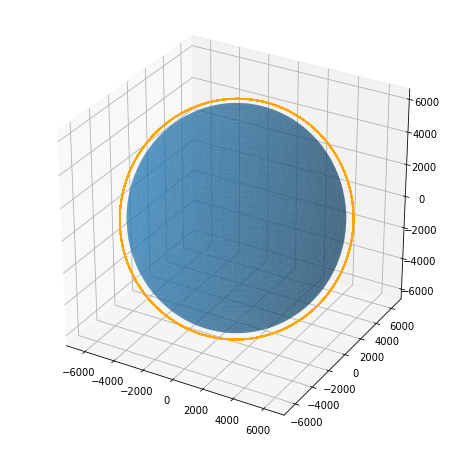

In [144]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

# Make Earth globe
a = np.linspace(0, 2 * np.pi, 100)
b = np.linspace(0, np.pi, 100)
x = 6378 * np.outer(np.cos(a), np.sin(b))
y = 6378 * np.outer(np.sin(a), np.sin(b))
z = 6371 * np.outer(np.ones(np.size(a)), np.cos(b))
ax.plot_surface(x, y, z, alpha=0.5)

plt.plot(position[0],position[1],position[2], 'orange')

## Adding earth rotation
Let's add the effect of the Earth's rotation so that we can plot our orbit in the Earth Centric, Earth Fixed (ECEF) reference frame. To do this, we convert our position over time to spherical coordinates, and remove the earth's 360deg/24h = 7.25e10-5  rad/s for each time step, before converting back to cartesian coordinates for plotting

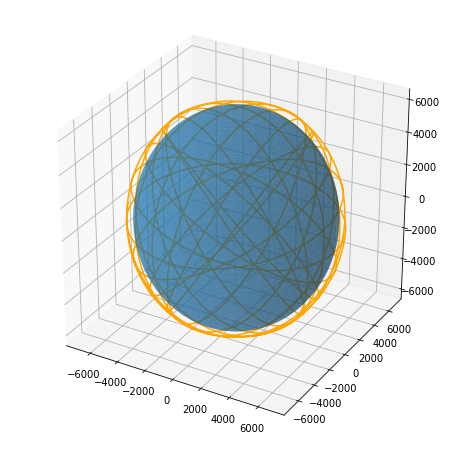

In [146]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def add_earth_rotation(position):
    azimuth,elevation,d = cart2sph(position[0],position[1],position[2])
    azimuth=azimuth-7.25*10**-5*sol.t
    r1,r2,r3 = sph2cart(azimuth,elevation,d)
    return [r1, r2, r3]

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z, alpha=0.5)

position_with_rotation = add_earth_rotation(position)
plt.plot(position_with_rotation[0],position_with_rotation[1],position_with_rotation[2], 'orange')

## Assessing Propagation accuracy
We can sample a random point of our position results and calculate the Orbital Elements from the State Vector at that moment, and compare to those computed initially from the TLE.

In [166]:
def SV2OE(r,v):
    norm = np.linalg.norm
    deg = np.degrees
    cross = np.cross
    acos = np.arccos
    atan = np.arctan
    sin = np.sin
    tan = np.tan
    dot= np.dot
    pi= np.pi
    mu=398600;
    r=np.array(r)
    v=np.array(v)
    
    e_vector=((norm(v)**2-mu/norm(r))*r-(dot(r,v)*v))/mu
    e=norm(e_vector)

    h=cross(r,v)
    i=acos(h[2]/norm(h))
    i=deg(i)

    a=norm(h)**2/mu/(1-e**2);
    n=(mu/a**3)**0.5;
    n=n*24*3600/2/pi;

    normal_vector=cross(np.array([0, 0, 1]),h);
    W=acos(normal_vector[0]/norm(normal_vector));
    W=deg(W)
    
    w=acos(dot(normal_vector,e_vector)/norm(normal_vector)/e);
    w = deg(w)
    
    if normal_vector[1]<0:
        W=360-W
    if e_vector[2]<0:
        w=360-w;

    f=acos(dot(e_vector,r)/norm(e)/norm(r));
    E=2*atan(((1-e)/(1+e))**0.5*tan(f/2));
    M=E-e*sin(E);
    M=M/pi*180;
    return e,i,n,W,w,M

In [170]:
from random import randint

velocity = sol.y[3:]
index = randint(0, len(t)) 

r_sample = [position[0][index], position[1][index], position[2][index]]
v_sample = [velocity[0][index], velocity[1][index], velocity[2][index]]

print(e,i,n,W,w,M)
e,i,n,W,w,M = SV2OE(r_sample,v_sample)
print(e,i,n,W,w,M)

0.0004962999999998821 51.6453 15.49564288208235 27.511599999999994 133.85789999998542 39.24570000090216
0.0004962984560364776 51.6453 15.495642583875126 27.511600000000023 133.857932646822 100.6116008372596


Orbital elements are conserved! Except of course for the mean anomaly.

## Orbit Prop J2

## Plotting Ground tracks